In [1]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pmdarima as pm
import xarray as xr
import pathlib
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data Transformation

In [2]:
data = pd.read_csv("../data/240k_full_data_proton_speed.csv")

In [3]:
data["time"]=pd.to_datetime(data["time"])

In [4]:
data.set_index("time", inplace=True)

In [5]:
data.interpolate(inplace=True) # filling none values with values of nearest points


In [6]:
data = data[['bt', 'bx_gse',
       'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm',
       'bz_gsm', 'theta_gsm', 'phi_gsm',"proton_speed"]] # taking only relevant features 

In [21]:
X = data.drop("proton_speed", axis=1)
y = data["proton_speed"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
scaler = StandardScaler()

In [9]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:

#convert the pandas object to a tensor
X_train = tf.convert_to_tensor(X_train)

X_test = tf.convert_to_tensor(X_test)


## Model 

In [77]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(11)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation="relu"))
model.add(keras.layers.Dense(1,activation="relu"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="mape")


In [78]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test,y_test), 
                    batch_size=32, 
                    epochs=200, callbacks=[keras.callbacks.EarlyStopping(
                                                        monitor='val_loss',
                                                        min_delta=0.00001,
                                                        patience=10,
                                                        baseline=None,
                                                        restore_best_weights=True
                                                    )],
                    shuffle=True
)


Epoch 1/200
6764/6764 [==============================] - 6s 783us/step - loss: 16.9560 - val_loss: 14.4469
Epoch 2/200
6764/6764 [==============================] - 5s 804us/step - loss: 14.3037 - val_loss: 14.2137
Epoch 3/200
6764/6764 [==============================] - 5s 762us/step - loss: 14.1256 - val_loss: 14.0505
Epoch 4/200
6764/6764 [==============================] - 5s 767us/step - loss: 14.0132 - val_loss: 14.0231
Epoch 5/200
6764/6764 [==============================] - 5s 768us/step - loss: 13.9474 - val_loss: 13.9081
Epoch 6/200
6764/6764 [==============================] - 5s 753us/step - loss: 13.8887 - val_loss: 13.9085
Epoch 7/200
6764/6764 [==============================] - 5s 779us/step - loss: 13.8351 - val_loss: 13.8526
Epoch 8/200
6764/6764 [==============================] - 5s 800us/step - loss: 13.8018 - val_loss: 13.8773
Epoch 9/200
6764/6764 [==============================] - 5s 790us/step - loss: 13.7731 - val_loss: 13.8796
Epoch 10/200
6764/6764 [=============

Epoch 77/200
6764/6764 [==============================] - 5s 803us/step - loss: 13.0949 - val_loss: 13.1864
Epoch 78/200
6764/6764 [==============================] - 5s 793us/step - loss: 13.0858 - val_loss: 13.2729
Epoch 79/200
6764/6764 [==============================] - 5s 777us/step - loss: 13.0832 - val_loss: 13.1842
Epoch 80/200
6764/6764 [==============================] - 5s 765us/step - loss: 13.0750 - val_loss: 13.1284
Epoch 81/200
6764/6764 [==============================] - 5s 771us/step - loss: 13.0691 - val_loss: 13.1157
Epoch 82/200
6764/6764 [==============================] - 5s 768us/step - loss: 13.0673 - val_loss: 13.1829
Epoch 83/200
6764/6764 [==============================] - 6s 828us/step - loss: 13.0682 - val_loss: 13.2758
Epoch 84/200
6764/6764 [==============================] - 5s 794us/step - loss: 13.0553 - val_loss: 13.2459
Epoch 85/200
6764/6764 [==============================] - 5s 798us/step - loss: 13.0521 - val_loss: 13.1423
Epoch 86/200
6764/6764 [====

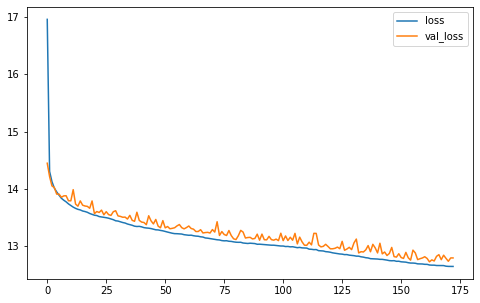

In [79]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


In [81]:
model.save("solar_wind_model_best")


INFO:tensorflow:Assets written to: solar_wind_model_best/assets


In [13]:
reconstructed_model = keras.models.load_model("solar_wind_model_best")

In [14]:
reconstructed_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 11)               23        
 ion)                                                            
                                                                 
 dense_45 (Dense)            (None, 16)                192       
                                                                 
 dense_46 (Dense)            (None, 32)                544       
                                                                 
 dense_47 (Dense)            (None, 16)                528       
                                                                 
 dense_48 (Dense)            (None, 8)                 136       
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                      

##  Prediction visualization 

In [22]:
predictions = reconstructed_model.predict(scaler.transform(X))

In [23]:
data["prediction"] = predictions

<AxesSubplot:xlabel='time'>

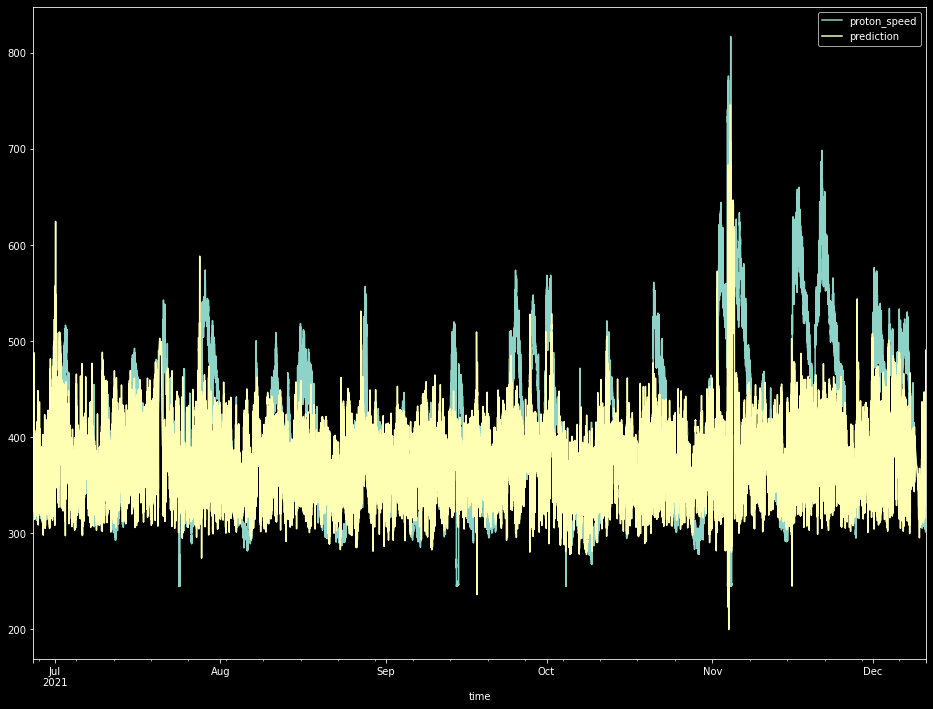

In [24]:
plt.style.use('dark_background')
data[["proton_speed","prediction"]].plot(figsize=(16,12))